In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

from plotting_tools import * 

In [2]:
memilio_pop = "pop8"
plot_path = f"../plots/infection_probs"
os.makedirs(plot_path, exist_ok=True)

In [3]:
person_locs = pd.read_csv("../../preprocessing/data/0_persons_locs.csv", sep=",", dtype=str)

person_locs['WorkSize'] = person_locs.groupby('Work')['Id'].transform('count')
person_locs.loc[person_locs['Work'] == str(-1), 'WorkSize'] = np.nan

person_locs['SchoolSize'] = person_locs.groupby('School')['Id'].transform('count')
person_locs.loc[person_locs['School'] == str(-1), 'SchoolSize'] = np.nan

person_locs['HomeSize'] = person_locs.groupby('Home')['Id'].transform('count')

person_locs['ShopSize'] = person_locs.groupby('Shop')['Id'].transform('count')

person_locs['SocialSize'] = person_locs.groupby('Event')['Id'].transform('count')

In [4]:
loc_mapping = pd.read_csv("../../preprocessing/data/1_mapping_tan_locs.txt", sep=r"\s+", dtype=str, header=None).iloc[:, [0, 1]]
loc_mapping.columns = ["ABM_id", "tan_id"]
loc_mapping_dict = loc_mapping.set_index("ABM_id")["tan_id"].to_dict()
person_locs["Home_ww_area"] = person_locs["Home"].map(loc_mapping_dict)

In [5]:
warnings.filterwarnings('ignore')

ts = 2208
def find_inf_agents(memilio_id):
    df = pd.read_csv(f"../../raw_memilio_data/{memilio_pop}/inf_paths/{memilio_id}_infection_paths.txt", sep=r"\s+", index_col=False)
    
    df["is_inf"] = np.where(df['S'] < ts, 1, 0)
    df["sim"] = memilio_id
    
    return df[["Agent_id", "is_inf", "sim"]]

inf_agents = pd.concat([find_inf_agents(memilio_id) for memilio_id in range(1, 101)])

In [6]:
inf_probs = inf_agents.groupby('Agent_id')['is_inf'].mean().reset_index().rename(columns={'is_inf': 'inf_prob'})
inf_probs['Agent_id'] = inf_probs['Agent_id'].apply(str)

In [7]:
inf_probs_merged = pd.merge(person_locs, inf_probs, left_on='Id', right_on='Agent_id', how='left')
inf_probs_merged = inf_probs_merged[["Agent_id", "WorkSize", "SchoolSize", "HomeSize", "ShopSize", "SocialSize", "inf_prob"]]

In [8]:
inf_probs_merged_filtered = inf_probs_merged[['WorkSize', 'inf_prob']].dropna()
r, p_value = pearsonr(inf_probs_merged_filtered['WorkSize'], inf_probs_merged_filtered['inf_prob'])
print(f"Pearson correlation coefficient: {r:.2f}")
print(f"P-value: {p_value:.3e}")

rho, p_value_rho = spearmanr(inf_probs_merged_filtered['WorkSize'], inf_probs_merged_filtered['inf_prob'])
print(f"Spearman correlation coefficient: {rho:.2f}")
print(f"P-value: {p_value_rho:.3e}")

Pearson correlation coefficient: 0.50
P-value: 0.000e+00
Spearman correlation coefficient: 0.56
P-value: 0.000e+00


In [9]:
inf_probs_summary = inf_probs_merged.groupby("WorkSize")["inf_prob"].agg(mean='mean', p05=lambda x: np.percentile(x, 5), p95=lambda x: np.percentile(x, 95)).reset_index()
asym_error = [inf_probs_summary["mean"] - inf_probs_summary["p05"], inf_probs_summary["p95"] - inf_probs_summary["mean"]]

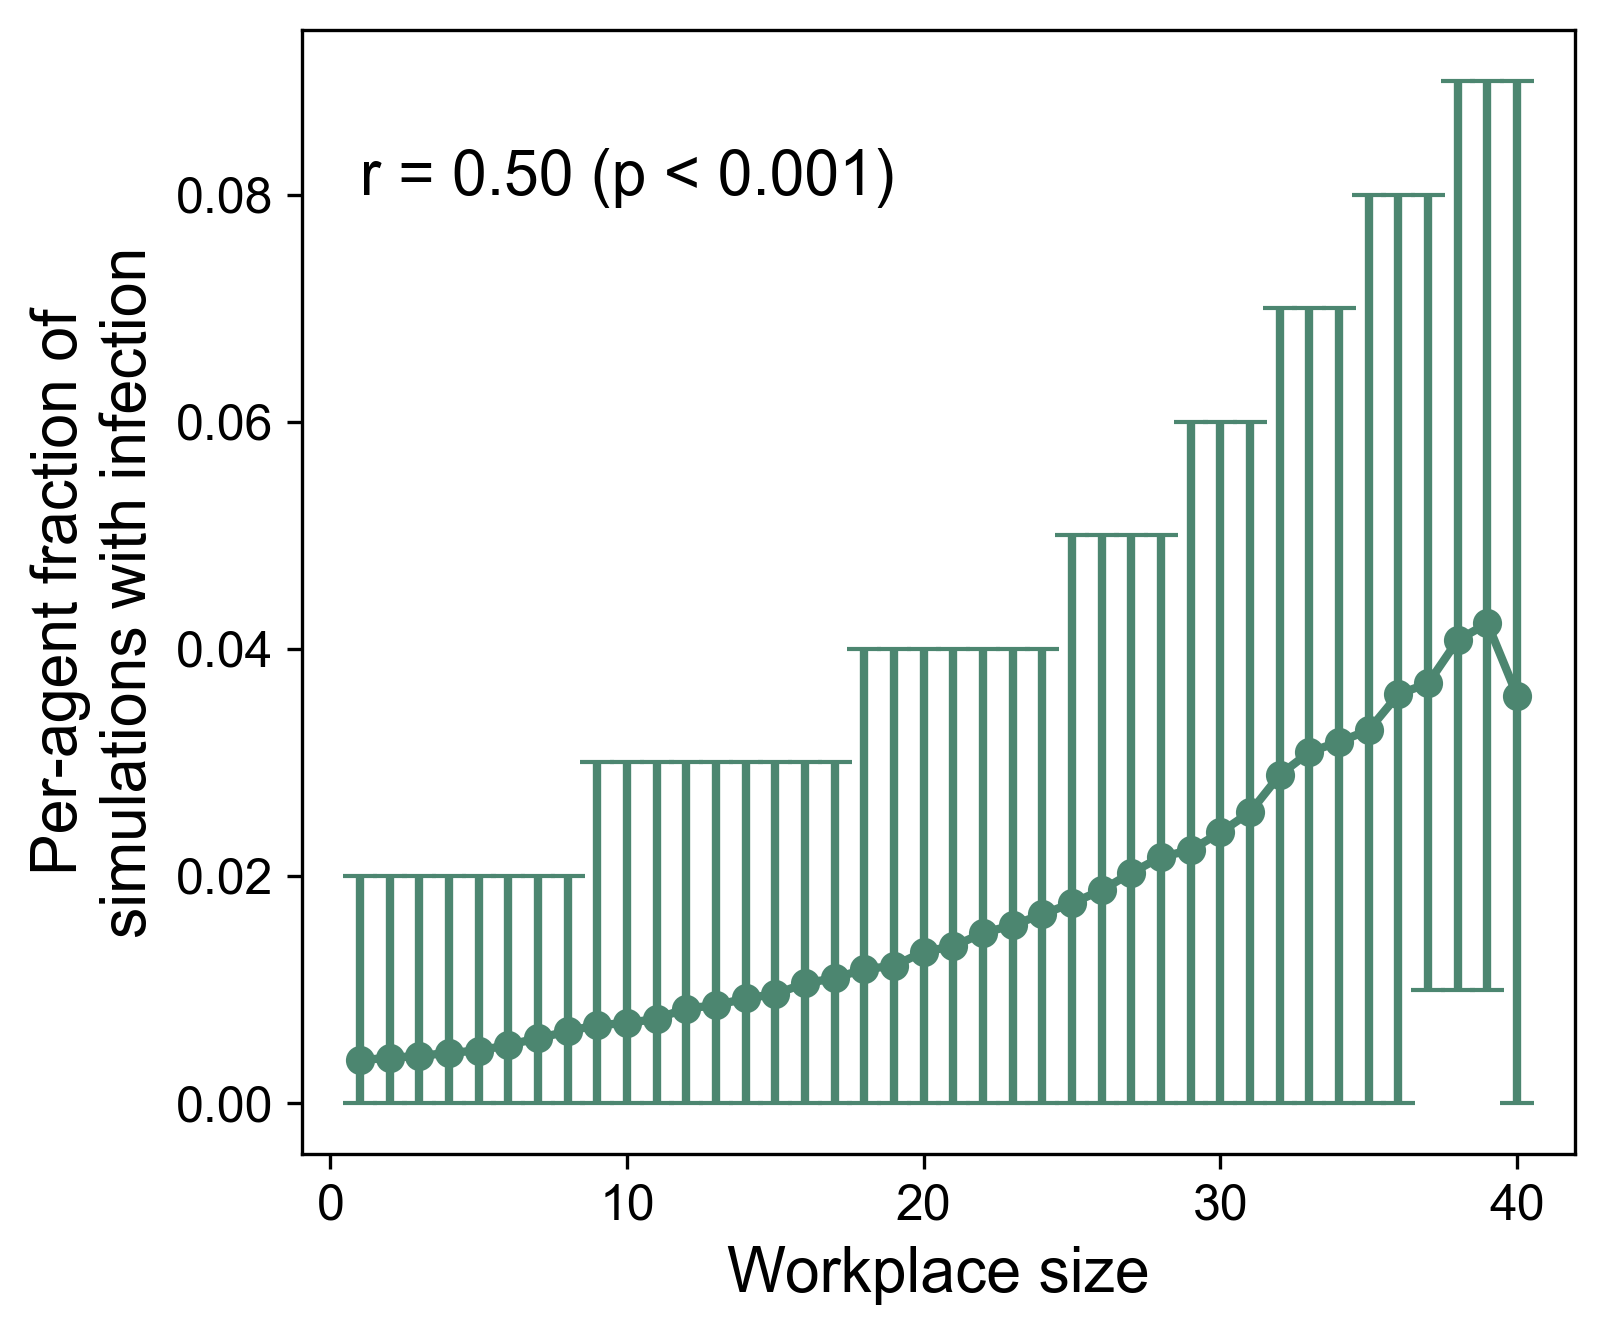

In [10]:
plt.style.use('default')
set_fontsize()

fig, ax = plt.subplots(figsize=(5.6, 4.7), dpi=300)

ax.errorbar(x = inf_probs_summary["WorkSize"], y= inf_probs_summary["mean"], yerr = asym_error, fmt='o-', capsize=4, color='#4C8670', ecolor='#4C8670', linewidth=2)
ax.set_ylabel("Per-agent fraction of\nsimulations with infection")
ax.set_xlabel("Workplace size")

ax.text(1, 0.08, f"r = {r:.2f} (p < 0.001)", fontsize = 15)

plt.tight_layout()
plt.savefig(f"{plot_path}/inf_by_work_size.png", dpi=300)
plt.show()

In [11]:
persons = pd.read_csv("../../preprocessing/data/persons.csv", sep=",")

In [12]:
loc_mapping = pd.read_csv("../../preprocessing/data/1_mapping_tan_locs.txt", sep=r"\s+", dtype=str, header=None).iloc[:, [0, 1]]
loc_mapping.columns = ["ABM_id", "tan_id"]
loc_mapping_dict = loc_mapping.set_index("ABM_id")["tan_id"].to_dict()

In [13]:
person_locs["Home_ww_area"] = person_locs["Home"].map(loc_mapping_dict)
person_locs["Work_ww_area"] = person_locs["Work"].map(loc_mapping_dict)
person_locs["School_ww_area"] = person_locs["School"].map(loc_mapping_dict)
person_locs["Shop_ww_area"] = person_locs["Shop"].map(loc_mapping_dict)
person_locs["Social_ww_area"] = person_locs["Event"].map(loc_mapping_dict)
person_locs["age"] = persons["age"]

In [14]:
person_locs["is_child"] = person_locs['age'].between(5, 15, inclusive = "both")
ww_areas = person_locs.groupby('Home_ww_area')['is_child'].mean().reset_index()

In [15]:
person_locs["is_worker"] = person_locs['age'].between(16, 59, inclusive = "both")
temp = person_locs.groupby('Home_ww_area')['is_worker'].mean().reset_index()
ww_areas = pd.merge(ww_areas, temp, on="Home_ww_area", how="left")
ww_areas.rename(columns={'Home_ww_area': 'ww_area', "is_child": "child_prop", "is_worker": "worker_prop"}, inplace=True)

In [16]:
mean_loc_sizes = person_locs.groupby('Home_ww_area')[['HomeSize', 'WorkSize', 'SchoolSize', 'SocialSize', 'ShopSize']].mean().reset_index()
ww_areas = pd.merge(ww_areas, mean_loc_sizes, left_on='ww_area', right_on='Home_ww_area', how='left')
ww_areas = ww_areas[["ww_area", "child_prop", "worker_prop", "HomeSize", "WorkSize", "SchoolSize", "SocialSize", "ShopSize"]].rename(columns={"WorkSize": "Res_WorkSize", "ShopSize": "Res_ShopSize", "SchoolSize": "Res_SchoolSize", "SocialSize": "Res_SocialSize"})

In [17]:
hospitals = loc_mapping[loc_mapping['ABM_id'].str.match(r'^05', na = False)].groupby('tan_id')['ABM_id'].count()
ww_areas = pd.merge(ww_areas, hospitals, left_on='ww_area', right_on='tan_id', how='left').rename(columns={'ABM_id': 'num_hosp'})
ww_areas["num_hosp"] = ww_areas["num_hosp"].fillna(0)

In [18]:
prev_by_area = pd.read_csv(f"../../raw_memilio_data/{memilio_pop}/num_agents_infections_area_{memilio_pop}.txt", sep=",") 
prev_by_area["prev"] = prev_by_area["NumInfected"] / prev_by_area["NumAgents"]
prev_by_area["area"] = prev_by_area["area"].apply(str) 

In [19]:
max_prev_per_sim = prev_by_area.groupby(['Sim', 'area'])['prev'].max().reset_index()
mean_max_prev = max_prev_per_sim.groupby(['area'])['prev'].mean().reset_index()

In [20]:
print(set(ww_areas['ww_area']) - set(mean_max_prev['area']))
ww_areas = pd.merge(ww_areas, mean_max_prev, left_on='ww_area', right_on='area', how='left')
ww_areas.head()

set()


,ww_area,child_prop,worker_prop,HomeSize,Res_WorkSize,Res_SchoolSize,Res_SocialSize,Res_ShopSize,num_hosp,area,prev
0,1,0.098762,0.596424,2.295736,23.933579,44.346797,230.048418,107.657221,1.0,1,0.006645
1,10,0.099770,0.600593,2.247284,27.878289,43.884488,242.547580,138.920316,0.0,10,0.008457
2,100,0.086844,0.588788,2.217758,25.383049,43.570896,142.530460,230.116656,0.0,100,0.007044
3,101,0.093136,0.594432,2.271698,25.540519,43.835165,167.262009,171.335630,0.0,101,0.005387
4,102,0.091369,0.594512,2.229496,30.081485,44.115772,359.444887,243.764372,0.0,102,0.009613


In [21]:
ww_areas_normalized = ww_areas.copy()
numeric_cols = ww_areas_normalized.select_dtypes(include=[np.number]).columns
ww_areas_normalized[numeric_cols] = (ww_areas_normalized[numeric_cols] - ww_areas_normalized[numeric_cols].min()) / (ww_areas_normalized[numeric_cols].max() - ww_areas_normalized[numeric_cols].min())
ww_areas_normalized.head()

,ww_area,child_prop,worker_prop,HomeSize,Res_WorkSize,Res_SchoolSize,Res_SocialSize,Res_ShopSize,num_hosp,area,prev
0,1,0.171034,0.775773,0.681170,0.112047,0.813551,0.195054,0.008752,0.333333,1,0.144762
1,10,0.178924,0.813234,0.512413,0.477321,0.607815,0.222684,0.056057,0.000000,10,0.353234
2,100,0.077695,0.707165,0.409576,0.246266,0.468260,0.001593,0.194047,0.000000,100,0.190579
3,101,0.126972,0.757880,0.597446,0.260847,0.585865,0.056263,0.105105,0.000000,101,0.000000
4,102,0.113135,0.758594,0.450459,0.681333,0.710740,0.481089,0.214698,0.000000,102,0.486228


In [22]:
X = ww_areas_normalized.drop(columns=["ww_area", "area", "prev"]) 
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data[vif_data["feature"] != "const"])

          feature       VIF
1      child_prop  2.186818
2     worker_prop  1.846152
3        HomeSize  1.219718
4    Res_WorkSize  1.696842
5  Res_SchoolSize  1.150934
6  Res_SocialSize  1.229433
7    Res_ShopSize  1.826227
8        num_hosp  1.032488


In [23]:
# child_prop: proportion of agents living in the ww area who are children
# worker_prop: proportion of agents living in the ww area who are working-age adults
# HomeSize: Mean household size in the area
# Res_WorkSize: Mean size of the workplaces of the area's working-age residents
# Res_SchoolSize: Mean size of the schools of the area's school-age residents
# Res_SocialSize: Mean size of the social events of the area's residents
# Res_ShopSize: Mean size of the shops of the area's residents
# num_res: number of agents living in the ww area
# num_worker: number of agents who work in the ww area (regardless of where they live)
# num_pupils: number of agents who attend school in the ww area (regardless of where they live)
# num_hosp: number of hospitals located in the ww area
# mean_people_per_workplace: mean size of the workplaces located within the ww area
# mean_people_per_school: mean size of the school locations located within the ww area
# mean_people_per_shop: mean size of the shop locations located within the ww area
# mean_people_per_social: mean size of the social event locations located within the ww area

formula = 'prev ~ child_prop + worker_prop + HomeSize + Res_WorkSize + Res_SchoolSize + Res_SocialSize + Res_ShopSize + num_hosp' 

model = smf.ols(formula = formula, data = ww_areas_normalized).fit()

results_df = pd.DataFrame({'coef': model.params,'p_value': model.pvalues})
results_df['p_value'] = results_df['p_value'].round(4)

print(results_df)
# significant: child_prop, Res_WorkSize, Res_SocialSize

                    coef  p_value
Intercept      -0.022374   0.8137
child_prop      0.626918   0.0000
worker_prop     0.154909   0.1628
HomeSize       -0.098429   0.1163
Res_WorkSize    0.090996   0.0547
Res_SchoolSize  0.025988   0.6432
Res_SocialSize  0.526408   0.0000
Res_ShopSize    0.112424   0.0827
num_hosp       -0.051957   0.3134
